In [1]:
# 08_metric_distribution_explorer.ipynb
# 📈 Metric Distribution Explorer

# Requirements: pandas, numpy, matplotlib, seaborn (install via `pip install pandas numpy matplotlib seaborn`)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("crest")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())



Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 🎯 What You'll Explore

> **Beginner tip:** Distributions can look busy at first glance. After each chart, say out loud whether the data is spread out or tightly clustered—simple descriptions help concepts stick.

Use this notebook to benchmark any tempo-free metric across Division I teams. You will:
- identify available seasons and filter to a league of interest
- select the metrics you want to review (tempo, shooting, possession, results)
- summarize distributional stats and visualize shapes to spot outliers
- flag teams that sit on the extreme ends of each distribution


In [2]:
# 📅 Discover available seasons
season_files = sorted(p.stem for p in (DATA_DIR / "team_season_stats").glob('*.csv'))
print(f"Available seasons ({len(season_files)}):")
print(', '.join(season_files[:10]))
if len(season_files) > 10:
    print('…')
    print(', '.join(season_files[-5:]))



Available seasons (21):
2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014
…
2021, 2022, 2023, 2024, 2025


## 🛠️ Set analysis parameters
Leave the defaults, then experiment with the metric list once you feel comfortable. Swapping metrics will automatically update every chart below.

Adjust these values, re-run the cell, and then execute the remaining steps.


In [7]:
# 🔁 Parameters
TARGET_SEASON = 2025  # choose any season listed above
TARGET_CONFERENCE = None  # e.g. 'Big Ten' to focus on one league, or None for all
MIN_GAMES = 10  # remove teams with tiny samples
SELECTED_METRICS = [
    "pace",
    "off_rating",
    "def_rating",
    "teamStats_fourFactors_effectiveFieldGoalPct",
    "teamStats_fourFactors_offensiveReboundPct",
    "opponentStats_fourFactors_effectiveFieldGoalPct",
    "opponentStats_fourFactors_offensiveReboundPct",
]
PLOT_KIND = "hist"  # 'hist' or 'kde'
BINS = 20  # histogram bins when PLOT_KIND == 'hist'
HIGHLIGHT_TEAMS = []  # e.g. ['Connecticut', 'South Carolina']

print(f"Analyzing season: {TARGET_SEASON}")
print(f"Conference filter: {TARGET_CONFERENCE or 'All'}")
print(f"Metrics selected: {len(SELECTED_METRICS)}")



Analyzing season: 2025
Conference filter: All
Metrics selected: 7


## 📚 Metric catalog
Review the catalog to learn what each metric represents. Keep it handy as a mini-glossary while you explore.

Skim the available metrics and confirm the ones you want to explore are listed with helpful labels.


In [8]:
# 🧾 Metric catalog
METRIC_CATALOG = {
    "pace": {"label": "Pace (possessions per game)", "category": "Tempo"},
    "off_rating": {"label": "Offensive Rating", "category": "Efficiency"},
    "def_rating": {"label": "Defensive Rating", "category": "Efficiency"},
    "net_rating": {"label": "Net Rating", "category": "Efficiency"},
    "teamStats_fourFactors_effectiveFieldGoalPct": {"label": "Offensive eFG%", "category": "Shooting"},
    "opponentStats_fourFactors_effectiveFieldGoalPct": {"label": "Defensive eFG%", "category": "Shooting"},
    "teamStats_fourFactors_offensiveReboundPct": {"label": "Offensive Rebound Rate", "category": "Possession"},
    "opponentStats_fourFactors_offensiveReboundPct": {"label": "Defensive Rebound Rate Allowed", "category": "Possession"},
    "teamStats_fourFactors_turnoverRatio": {"label": "Turnover Rate", "category": "Possession"},
    "teamStats_fourFactors_freeThrowRate": {"label": "Free Throw Rate", "category": "Shooting"},
    "teamStats_trueShooting": {"label": "True Shooting%", "category": "Shooting"},
    "points_per_game": {"label": "Points Per Game", "category": "Scoring"},
    "opp_points_per_game": {"label": "Opponent Points Per Game", "category": "Scoring"},
    "margin_per_game": {"label": "Scoring Margin Per Game", "category": "Scoring"},
    "win_pct": {"label": "Win Percentage", "category": "Results"}
}

metric_catalog_df = (
    pd.DataFrame.from_dict(METRIC_CATALOG, orient="index")
    .reset_index()
    .rename(columns={"index": "metric"})
    .sort_values(["category", "metric"])
)

print(f"Cataloged metrics: {len(metric_catalog_df)}")
display(metric_catalog_df)

missing_metadata = [m for m in SELECTED_METRICS if m not in METRIC_CATALOG]
if missing_metadata:
    print("⚠️ Add metadata for:", ', '.join(missing_metadata))



Cataloged metrics: 15


,metric,label,category
2,def_rating,Defensive Rating,Efficiency
3,net_rating,Net Rating,Efficiency
1,off_rating,Offensive Rating,Efficiency
7,opponentStats_fourFactors_offensiveReboundPct,Defensive Rebound Rate Allowed,Possession
6,teamStats_fourFactors_offensiveReboundPct,Offensive Rebound Rate,Possession
8,teamStats_fourFactors_turnoverRatio,Turnover Rate,Possession
14,win_pct,Win Percentage,Results
13,margin_per_game,Scoring Margin Per Game,Scoring
12,opp_points_per_game,Opponent Points Per Game,Scoring
11,points_per_game,Points Per Game,Scoring


## 📥 Load season data
This step loads the team season table that powers all later visuals. If the preview feels overwhelming, remember you only need a handful of columns for the charts.

Each team-season file includes finalized tempo-free stats. Filter to the teams that match your parameters.


In [9]:
# 🗂️ Read team season stats
team_season_path = DATA_DIR / 'team_season_stats' / f'{TARGET_SEASON}.csv'
team_season = pd.read_csv(team_season_path)

print(f"Loaded {team_season.shape[0]} rows and {team_season.shape[1]} columns")

team_season = team_season.dropna(subset=['conference']).copy()
team_season['games'] = team_season['games'].fillna(0)
team_season = team_season.loc[team_season['games'] >= MIN_GAMES].copy()

if TARGET_CONFERENCE:
    team_season = team_season.loc[team_season['conference'] == TARGET_CONFERENCE].copy()

if team_season.empty:
    raise ValueError('No teams remain after applying filters. Relax your parameters.')

print(f"Teams after filtering: {team_season['team'].nunique()}")
print(team_season[['team', 'conference', 'games']].head())



Loaded 364 rows and 78 columns
Teams after filtering: 364
                team     conference  games
0  Abilene Christian            WAC     32
1          Air Force  Mountain West     32
2              Akron            MAC     35
3        Alabama A&M           SWAC     32
4            Alabama            SEC     37


## 🧮 Derive analysis frame
We collect the selected metrics into one tidy DataFrame so the plotting functions stay simple. Check that the column list matches what you selected above.

Create handy columns (net rating, per-game scoring, win percentage) and keep the measurements you'll chart.


In [10]:
# 🧮 Build metric frame
metric_frame = (
    team_season.assign(
        off_rating=lambda df: df['teamStats_rating'],
        def_rating=lambda df: df['opponentStats_rating'],
        net_rating=lambda df: df['teamStats_rating'] - df['opponentStats_rating'],
        points_per_game=lambda df: df['teamStats_points_total'] / df['games'].replace({0: np.nan}),
        opp_points_per_game=lambda df: df['opponentStats_points_total'] / df['games'].replace({0: np.nan}),
        margin_per_game=lambda df: (df['teamStats_points_total'] - df['opponentStats_points_total']) / df['games'].replace({0: np.nan}),
        win_pct=lambda df: df['wins'] / df['games'].replace({0: np.nan}),
    )
    .rename(columns={
        'teamStats_fourFactors_offensiveReboundPct': 'teamStats_fourFactors_offensiveReboundPct',
    })
)

metric_columns = ['team', 'conference', 'games'] + [col for col in METRIC_CATALOG if col in metric_frame.columns]
metric_frame = metric_frame[metric_columns].copy()

available_metrics = set(metric_frame.columns)
missing_metrics = [metric for metric in SELECTED_METRICS if metric not in available_metrics]
if missing_metrics:
    raise KeyError(f"Missing metrics in dataset: {missing_metrics}")

print(f"Metric frame shape: {metric_frame.shape}")
display(metric_frame.head())



Metric frame shape: (364, 18)


,team,conference,games,pace,off_rating,def_rating,net_rating,teamStats_fourFactors_effectiveFieldGoalPct,opponentStats_fourFactors_effectiveFieldGoalPct,teamStats_fourFactors_offensiveReboundPct,opponentStats_fourFactors_offensiveReboundPct,teamStats_fourFactors_turnoverRatio,teamStats_fourFactors_freeThrowRate,teamStats_trueShooting,points_per_game,opp_points_per_game,margin_per_game,win_pct
0,Abilene Christian,WAC,32,66.40,103.80,103.50,0.30,48.30,50.00,32.90,29.10,0.22,36.10,52.90,70.62,70.28,0.34,0.50
1,Air Force,Mountain West,32,61.10,98.90,117.90,-19.00,50.10,54.60,24.70,26.80,0.22,35.40,53.10,61.94,73.66,-11.72,0.12
2,Akron,MAC,35,69.10,120.50,107.40,13.10,55.20,49.40,30.70,30.60,0.17,26.10,58.40,84.03,75.00,9.03,0.80
3,Alabama A&M,SWAC,32,61.50,114.70,124.50,-9.80,47.00,53.10,38.10,30.90,0.25,37.50,51.00,73.03,78.78,-5.75,0.31
4,Alabama,SEC,37,74.50,119.30,106.90,12.40,56.60,47.80,29.30,33.90,0.17,39.30,60.30,90.68,81.27,9.41,0.76


## 📊 Summarize distribution stats
These summary stats (mean, median, std) help you interpret the plots. Compare them to see whether a distribution is skewed.

Compute descriptive statistics for each selected metric to frame the distribution before plotting.


In [11]:
# 📊 Summary table
value_columns = [col for col in SELECTED_METRICS if col in metric_frame.columns]
label_map = {metric: METRIC_CATALOG.get(metric, {}).get('label', metric) for metric in value_columns}

long_metrics = (
    metric_frame.melt(
        id_vars=['team', 'conference'],
        value_vars=value_columns,
        var_name='metric',
        value_name='value'
    )
    .dropna(subset=['value'])
)
long_metrics['metric_label'] = long_metrics['metric'].map(label_map)

summary_stats = (
    long_metrics.groupby(['metric', 'metric_label'])
    .agg(
        teams=('team', 'nunique'),
        mean=('value', 'mean'),
        median=('value', 'median'),
        std=('value', 'std'),
        p10=('value', lambda s: s.quantile(0.10)),
        p90=('value', lambda s: s.quantile(0.90))
    )
    .reset_index()
    .sort_values('metric_label')
)

summary_display = summary_stats.copy()
for column in ['mean', 'median', 'std', 'p10', 'p90']:
    summary_display[column] = summary_display[column].round(2)

display(summary_display)



,metric,metric_label,teams,mean,median,std,p10,p90
0,def_rating,Defensive Rating,364,108.62,108.30,6.44,100.96,115.91
3,opponentStats_fourFactors_offensiveReboundPct,Defensive Rebound Rate Allowed,364,29.78,29.70,2.32,26.80,32.60
2,opponentStats_fourFactors_effectiveFieldGoalPct,Defensive eFG%,364,50.43,50.45,2.49,47.20,53.67
1,off_rating,Offensive Rating,364,110.93,111.00,6.87,102.13,119.27
6,teamStats_fourFactors_offensiveReboundPct,Offensive Rebound Rate,364,29.75,29.90,3.61,24.63,34.40
5,teamStats_fourFactors_effectiveFieldGoalPct,Offensive eFG%,364,51.31,51.25,2.84,47.63,55.17
4,pace,Pace (possessions per game),364,65.14,65.30,3.16,61.20,68.80


## 📈 Visualize distributions
Read the axis labels carefully and note anything unusual—heavy tails, multi-modal shapes, or tight clusters all tell different stories.

Use histograms or density plots to inspect the shape of each metric. Optional highlights mark teams you care about.


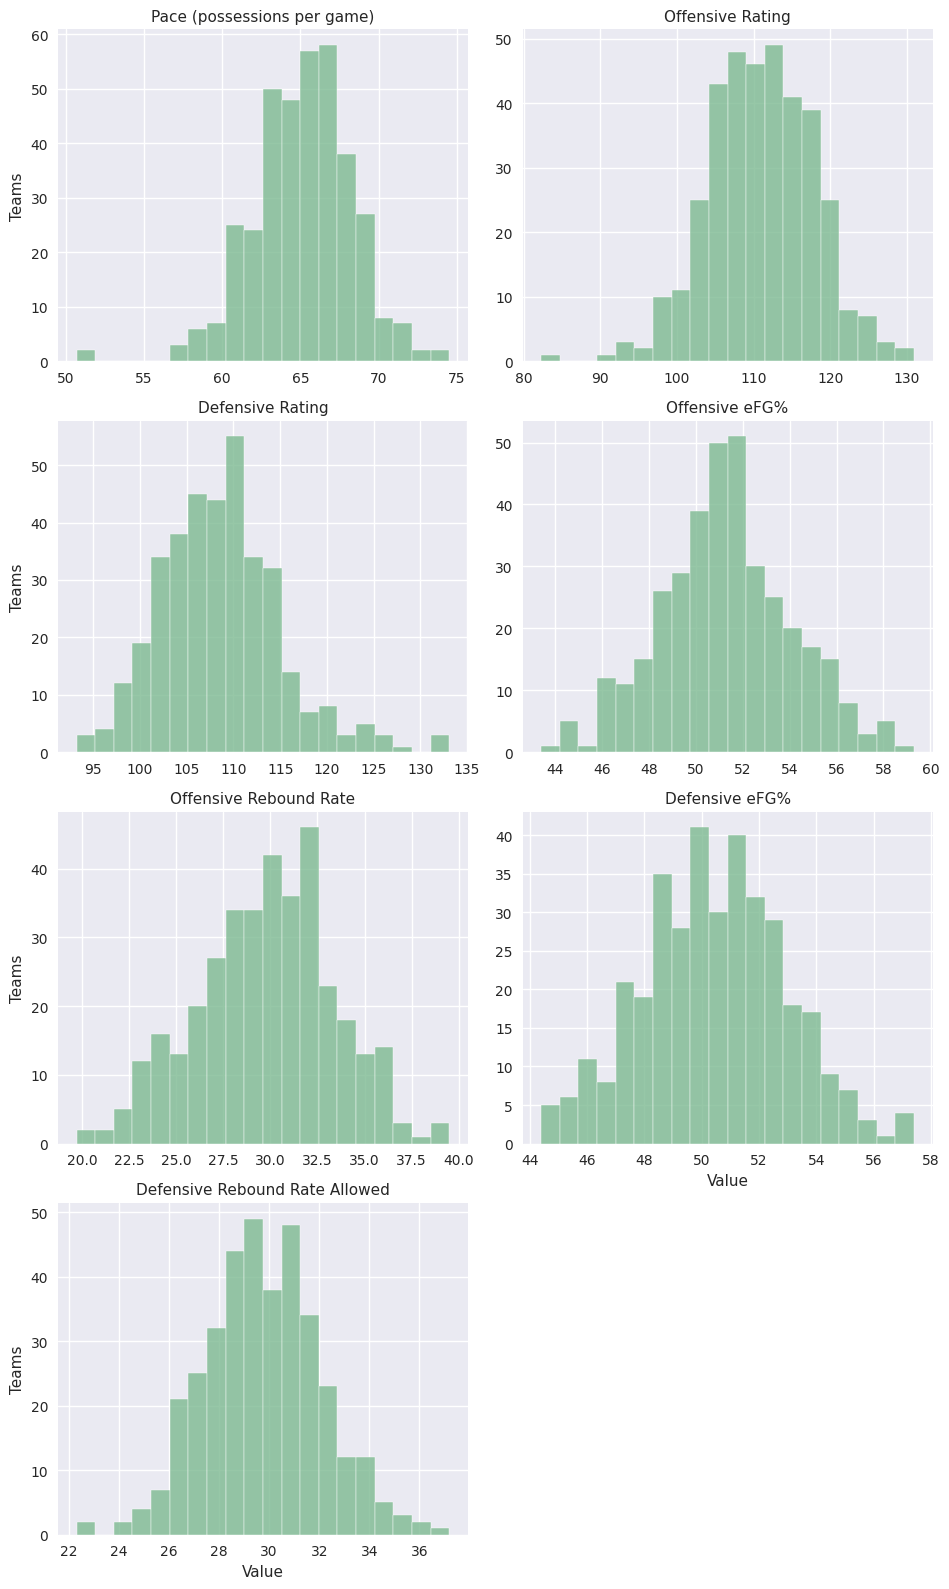

In [12]:
# 📈 Distribution plots
if PLOT_KIND not in {'hist', 'kde'}:
    raise ValueError("PLOT_KIND must be 'hist' or 'kde'")

plot_data = long_metrics.copy()
plot_data['metric_label'] = plot_data['metric_label'].fillna(plot_data['metric'])
unique_metrics = plot_data['metric'].unique().tolist()

height = 4
aspect = 1.2

g = sns.FacetGrid(
    plot_data,
    col='metric_label',
    col_wrap=2,
    sharex=False,
    sharey=False,
    height=height,
    aspect=aspect
)

if PLOT_KIND == 'hist':
    g.map_dataframe(sns.histplot, x='value', bins=BINS, edgecolor='white', alpha=0.8)
else:
    g.map_dataframe(sns.kdeplot, x='value', fill=True)

g.set_titles('{col_name}')
g.set_xlabels('Value')
g.set_ylabels('Teams')

if HIGHLIGHT_TEAMS:
    highlight_df = plot_data[plot_data['team'].isin(HIGHLIGHT_TEAMS)]
    for ax, metric in zip(g.axes.flat, unique_metrics):
        metric_highlights = highlight_df.loc[highlight_df['metric'] == metric]
        for _, row in metric_highlights.iterrows():
            ax.axvline(row['value'], color='crimson', linestyle='--', linewidth=1.5)
            ax.text(
                row['value'],
                ax.get_ylim()[1] * 0.85,
                row['team'],
                color='crimson',
                rotation=90,
                va='top',
                ha='right',
                fontsize=9,
                backgroundcolor='white'
            )

plt.tight_layout()
plt.show()



## 🏆 Spot the extremes
Leaderboards surface the teams far from the mean. When you find an extreme, think about why their style produces that outcome.

Surface the teams that lead or lag the field for each metric. Adjust the counts if you need deeper scouting lists.


In [13]:
# 🏆 Highs and lows
extreme_rows = []
for metric in value_columns:
    metric_label = label_map.get(metric, metric)
    top_slice = metric_frame.nlargest(5, metric)[['team', 'conference', metric]].assign(direction='High')
    bottom_slice = metric_frame.nsmallest(5, metric)[['team', 'conference', metric]].assign(direction='Low')
    combined = pd.concat([top_slice, bottom_slice], ignore_index=True)
    combined['metric'] = metric
    combined['metric_label'] = metric_label
    combined = combined.rename(columns={metric: 'value'})
    extreme_rows.append(combined)

extreme_table = (
    pd.concat(extreme_rows, ignore_index=True)
    .sort_values(['metric_label', 'direction', 'value'], ascending=[True, False, False])
)
extreme_table['value'] = extreme_table['value'].round(2)

display(extreme_table[['metric_label', 'direction', 'team', 'conference', 'value']])



,metric_label,direction,team,conference,value
29,Defensive Rating,Low,Saint Mary's,WCC,96.50
28,Defensive Rating,Low,Duke,ACC,95.40
27,Defensive Rating,Low,Central Connecticut,NEC,95.00
26,Defensive Rating,Low,Houston,Big 12,93.30
25,Defensive Rating,Low,St. John's,Big East,93.20
...,...,...,...,...,...
0,Pace (possessions per game),High,Alabama,SEC,74.50
1,Pace (possessions per game),High,South Carolina Upstate,Big South,73.60
2,Pace (possessions per game),High,Cal Poly,Big West,72.60
3,Pace (possessions per game),High,Winthrop,Big South,72.20


## ✅ Next steps
Bring your observations into other notebooks. Knowing whether a stat is rare or common makes your scouting reports stronger.

- Layer in multiple seasons by concatenating files to see how distributions shift year over year.
- Swap `SELECTED_METRICS` with lineup-specific stats (e.g., `team_game_stats`) for granular scouting.
- Export `summary_stats` or `extreme_table` to CSV to plug into dashboards or scouting reports.
